In [2]:
import sys
import subprocess
import json
import os
import matplotlib.pyplot as plt
import logging
from functools import reduce

# Disable logging of the program in the notebook
os.environ["LOGLEVEL"] = "CRITICAL"

logging.basicConfig()
logging.root.setLevel(logging.INFO)
logging.basicConfig(level=logging.INFO)

logger = logging.getLogger('__main__')
logger.setLevel(os.environ.get("LOGLEVEL", logging.FATAL))

pybooklogger = logging.getLogger('pybook')
pybooklogger.setLevel(logging.INFO)

from generation import generate
from parseRePEAT import *

In [3]:
previous_beta = 0

def plot_atf(segments, label, color, eatfs, fig, axs):
    global previous_beta
    line = None
    for (x0, x1, y0, y1) in segments:
        if x0 == "-inf" and x1 != "inf" and y1 != "inf":
            axs[0].hlines(float(y1), 0, float(x1), colors=color)
        line, = axs[0].plot([float(x0), float(x1)], [float(y0), float(y1)], color=color)
    line.set_label(label) if line is not None else None

    for (zeta, alpha, beta, delta, gammas) in list(eatfs.values())[0]:
        min_gammas = [float(gamma[0]) for gamma in gammas]
        min_gamma = sum(min_gammas)

        length_edge = max(0.0, float(beta)-float(alpha))
        max_gammas = [float(gamma[1]) for gamma in gammas]
        max_gamma = sum(max_gammas)
        alpha = float(alpha)
        beta = float(beta)
        gamma_diff = max_gamma - min_gamma
        if length_edge > gamma_diff:
            axs[1].plot([alpha, beta - gamma_diff], [min_gamma, min_gamma], color=color)
            alpha = beta - gamma_diff

        if alpha <= beta:
            axs[1].plot([previous_beta, alpha], [min_gamma, min_gamma], color=color)
            axs[1].plot([alpha, beta], [min_gamma, max_gamma], color=color)
        else:
            axs[1].plot([previous_beta, beta - (gamma_diff)], [min_gamma, min_gamma], color=color)
            axs[1].plot([beta - (gamma_diff), beta], [min_gamma, max_gamma], color=color)
        # axs[1].plot([float(alpha), float(beta)], [min_gammas, max_gammas], color=color)
        previous_beta = beta

        pybooklogger.info(f"{alpha}, {beta}, {gammas}, {min_gammas} - {max_gammas}")


station_maps = {}
def cache_station_map(layout):
    if layout not in station_maps:
        station_maps[layout] = generate.create_station_map(layout)
    return station_maps[layout]
    

def generate_intervals(max_buffer, use_recovery_time, layout, scenario, agent, agent_speed, move, fig, axs, color, label=None):
    # Generate intervals
    # generate.time_safe_intervals_and_write(layout, scenario, agent["trainNumber"], agent_speed, "output", max_buffer, use_recovery_time)
    pybooklogger.info(f" -------------------- {label} -------------------- ")
    global previous_beta
    previous_beta = 0
    station_map = cache_station_map(layout)
    move["startTime"] = 0
    start = station_map[move["startLocation"]]   if move["startLocation"] in station_map else move["startLocation"]
    end =   station_map[move["endLocation"]]     if move["endLocation"]   in station_map else move["endLocation"]
    generate.time_safe_intervals_and_write(layout, scenario, -1, agent_speed, "output", max_buffer, use_recovery_time, destination=end)
    timeout = 600
    try:
        # proc = subprocess.run(["atsipp.exe", "--start", start, "--goal", "r-14", "--edgegraph", "output", "--search", "repeat", "--startTime", str(move["startTime"])], timeout=20, stdout=subprocess.PIPE, stderr=subprocess.DEVNULL)
        proc = subprocess.run(["""C:\\Users\\erick\\Documents\\Uni\\Thesis\\delay-replanning-slack\\search\\buildDir\\atsipp.exe""", "--start", start, "--goal", end, "--edgegraph", "output", "--search", "repeat", "--startTime", str(move["startTime"])], timeout=timeout, stdout=subprocess.PIPE, stderr=subprocess.DEVNULL)

    except subprocess.TimeoutExpired:
        pybooklogger.info(f'Timeout for repeat ({timeout}s) expired')
        return
    repeat_output = str(proc.stdout).split("'")[1].rsplit("\\r\\n")

    # If the run was successful
    if int(proc.returncode) == 0:
        metadata, catf, paths, eatfs = parse_list_of_outputs(repeat_output)
        pybooklogger.info(f"eats: {eatfs}")
        pybooklogger.info(f"cats: {catf}")
        label = label if label else f"{max_buffer} seconds buffer time"
        plot_atf(catf, label, color, eatfs, fig, axs)

INFO:pybook: -------------------- Recovery time -------------------- 


KeyError: 't-14A'

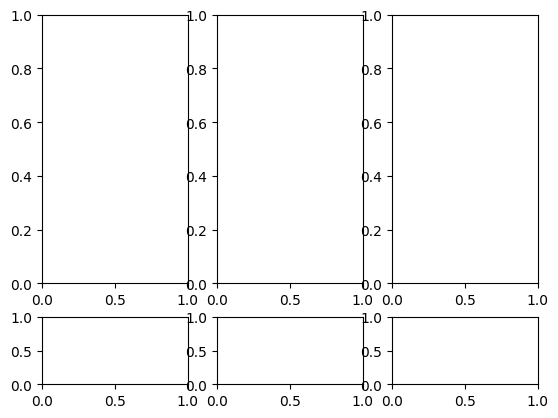

In [3]:
# Run RePeAT to get multiple plans
# scenario = "../data/single_track/scenario_following.json"
scenario = "../data/single_track/scenario_following.json"
layout =   "../data/single_track/woho.json"

scenario_data = json.load(open(scenario))
train_types = {x["name"]: x for x in scenario_data["types"]}
agent_speed = 30
max_buffer = 500

widths = [4, 4, 4]
heights = [4, 1]

for agent in scenario_data['trains']:
    # Get the global end time of scenario
    scenario_end_time = 0
    for i in range(len(agent["movements"])):
        move = agent["movements"][i]
        if 2 * move["endTime"] > scenario_end_time:
            scenario_end_time = 2 * move["endTime"]
    # agent_speed = train_types[agent["trainUnitTypes"][0]]["speed"] * 1.09
    for move in agent["movements"]:
        fig, axs = plt.subplots(ncols=3, nrows=2, gridspec_kw={"height_ratios": heights, "width_ratios": widths})
        axs = axs.transpose()
        generate_intervals(max_buffer, True,  layout, scenario, agent, agent_speed, move, fig, axs[:][2], color="green", label="Recovery time")
        generate_intervals(max_buffer, False, layout, scenario, agent, agent_speed, move, fig, axs[:][1], color="blue",  label="With buffer time")
        generate_intervals(0,          False, layout, scenario, agent, agent_speed, move, fig, axs[:][0], color="red",   label="No flexibility")

        # generate_intervals(float("inf"), True, layout, scenario, agent, 30, move, fig, axs, color="green", label="v=30")
        # generate_intervals(float("inf"), True, layout, scenario, agent, 20, move, fig, axs, color="blue", label="v=20")
        # generate_intervals(float("inf"), True, layout, scenario, agent, 10, move, fig, axs, color="red", label="v=10")
        #
        # Difference
        # generate_intervals(1000, True, layout, scenario, agent, 30, move, fig, axs, color="green", label="bt_max=1000")
        # generate_intervals(500,  True, layout, scenario, agent, 30, move, fig, axs, color="blue",  label="bt_max=500")
        # generate_intervals(100,  True, layout, scenario, agent, 30, move, fig, axs, color="red",   label="bt_max=100")

        # baseline

        def set_axis(ax, title):

            # title = f"Agent: {agent['trainNumber']}"
            axs[ax][0].set_xlabel("Departure time (s)")
            axs[ax][1].set_xlabel("Departure time (s)")
            axs[ax][0].set_ylabel("Arrival time (s)")
            axs[ax][1].set_ylabel("Total delay of agents (s)")
            axs[ax][0].set_title(title)
            # axs[0][0].legend()
            axs[ax][0].grid()
            axs[ax][1].grid()
            # axs[0].set_xlim([-50, 2550])
            # axs[1].set_xlim([-50, 2550])
            # axs[1].set_ylim([-50, 500])
            fig.set_figheight(7)
            fig.set_figwidth(15)

        set_axis(2, "Recovery time")
        set_axis(1, "Buffer time")
        set_axis(0, "No flexibility")
        plt.savefig(f"figures/atf_{agent['trainNumber']}")
        plt.show()
        break
    break



In [ ]:
generate.time_safe_intervals_and_write(layout, scenario, -1, agent_speed, "output", max_buffer, True, destination="r-14", plot=1)
generate.time_safe_intervals_and_write(layout, scenario, -1, agent_speed, "output", max_buffer, False, destination="r-14", plot=1)
generate.time_safe_intervals_and_write(layout, scenario, -1, agent_speed, "output", 0, False, destination="r-14", plot=1)


In [ ]:
# Run RePeAT to get multiple plans
# scenario = "../data/single_track/scenario_toy.json"
scenario = "../data/prorail/scenarios/scenario_sprinters.json"
layout =   "../data/prorail/parsed/netherlands-schiphol.json"

scenario_data = json.load(open(scenario))
train_types = {x["name"]: x for x in scenario_data["types"]}
agent_speed = 30
max_buffer = 500

widths = [10]
heights = [4, 1]

for agent in scenario_data['trains']:
    # Get the global end time of scenario
    scenario_end_time = 0
    for i in range(len(agent["movements"])):
        move = agent["movements"][i]
        if 2 * move["endTime"] > scenario_end_time:
            scenario_end_time = 2 * move["endTime"]
    # agent_speed = train_types[agent["trainUnitTypes"][0]]["speed"] * 1.09
    for move in agent["movements"]:
        fig, axs = plt.subplots(ncols=1, nrows=2, gridspec_kw={"height_ratios": heights, "width_ratios": widths})
        axs = axs.transpose()
        generate_intervals(max_buffer, True,  layout, scenario, agent, agent_speed, move, fig, axs, color="green", label="Recovery time")
        generate_intervals(max_buffer, False, layout, scenario, agent, agent_speed, move, fig, axs, color="blue",  label="With buffer time")
        generate_intervals(0,          False, layout, scenario, agent, agent_speed, move, fig, axs, color="red",   label="No flexibility")

        # generate_intervals(float("inf"), True, layout, scenario, agent, 30, move, fig, axs, color="green", label="v=30")
        # generate_intervals(float("inf"), True, layout, scenario, agent, 20, move, fig, axs, color="blue", label="v=20")
        # generate_intervals(float("inf"), True, layout, scenario, agent, 10, move, fig, axs, color="red", label="v=10")
        #
        # Difference
        # generate_intervals(1000, True, layout, scenario, agent, 30, move, fig, axs, color="green", label="bt_max=1000")
        # generate_intervals(500,  True, layout, scenario, agent, 30, move, fig, axs, color="blue",  label="bt_max=500")
        # generate_intervals(100,  True, layout, scenario, agent, 30, move, fig, axs, color="red",   label="bt_max=100")

        # baseline

        def set_axis(ax, title):

            # title = f"Agent: {agent['trainNumber']}"
            axs[0].set_xlabel("Departure time (s)")
            axs[1].set_xlabel("Departure time (s)")
            axs[0].set_ylabel("Arrival time (s)")
            axs[1].set_ylabel("Total delay of agents (s)")
            axs[0].set_title(title)
            # axs[0][0].legend()
            axs[0].grid()
            axs[1].grid()
            # axs[0].set_xlim([-50, 2550])
            # axs[1].set_xlim([-50, 2550])
            # axs[1].set_ylim([-50, 500])
        fig.set_figheight(7)
        fig.set_figwidth(15)

        # set_axis(2, "Recovery time")
        # set_axis(1, "Buffer time")
        set_axis(0, "No flexibility")
        plt.savefig(f"figures/atf_{agent['trainNumber']}")
        plt.show()
        break
    break



INFO:pybook: -------------------- Recovery time -------------------- 
INFO:pybook:eats: {'r-Shl|1080;r-Shl|1098;r-Hfd_Shl|1757;r-Hfd_Shl|1771;r-Hfd|1106;r-Hfd|1132;r-Hfd|1148;r-Hfd|1202;r-Hfd|1228;r-Hfd_Ledn|1969;r-Hfd_Ledn|1971;r-Hfd_Ledn|1973;r-Hfd_Ledn|1975;r-Hfd_Ledn|1977;r-Hfd_Ledn|1979;r-Hfd_Ledn|1981;r-Hfd_Ledn|1983;r-Hfd_Ledn|1985;r-Hfd_Ledn|1987;r-Hfd_Ledn|1991;r-Ledn|1010;r-Ledn|1050;r-Ledn|1094;r-Gvm_Ledn|807;r-Gvm_Ledn|817;r-Gvm_Ledn|827;r-Gvm_Ledn|837;r-Gvm_Ledn|847;r-Gvm_Ledn|857;r-Gvm|158;r-Gvm|186;r-Laa|529;r-Laa|537;r-Laa|94;r-Gvc|5020;r-Gvc|5080': [('-inf', '0', '1.81005', '1406.43', [['0', '0', '0'], ['1.98307', '3.79312', '0'], ['0', '0', '0'], ['0', '0', '0'], ['0', '0', '0'], ['0', '0', '0']]), ('-inf', '1.81005', '7.30582', '1406.43', [['0', '0', '0'], ['3.79312', '9.28889', '0'], ['0', '0', '0'], ['0', '0', '0'], ['0', '0', '0'], ['0', '0', '0']]), ('-inf', '7.30582', '9.58095', '1406.43', [['0', '0', '0'], ['9.28889', '11.564', '0'], ['0', '0', '0'], ['0', '0',

In [ ]:
generate.time_safe_intervals_and_write(layout, scenario, -1, agent_speed, "output", max_buffer, True, destination="r-Rtd|340", plot=1)
generate.time_safe_intervals_and_write(layout, scenario, -1, agent_speed, "output", max_buffer, False, destination="r-Rtd|340", plot=1)
generate.time_safe_intervals_and_write(layout, scenario, -1, agent_speed, "output", 0, False, destination="r-Rtd|340", plot=1)